In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import star_privateer as sp
import sys

# this is needed when importing from the notebooks folder
sys.path.append("../")
from lobster import Lightcurve
from lobster.filtering import sin4_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def starprivateer_wrapper(
    lc,
    type_prot_analysis="LS",
    pmin=0.5,
    pmax=60,
    plot_periodogram="True",
):
    all_parameters = {}
    t = lc.time - lc.time[0]
    s = lc.flux
    dt = np.median(np.diff(t))

    if type_prot_analysis == "LS":
        # ------------ LS Analysis
        # --------------------------------------------------------------
        (p_ps, p_acf, ps, acf, cs, features, feature_names, fig_rot) = sp.analysis_pipeline(
            t,
            s,
            pmin=pmin,
            pmax=pmax,
            figsize=(8, 10),
            wavelet_analysis=False,
            plot=True,
            xlim=[0, pmax],
            add_periodogram=plot_periodogram,
        )
    else:
        # ------------ Wavelet Analysis
        # --------------------------------------------------------------
        (p_acf, periods_wps, gwps, wps, acf, cs, coi, features, feature_names, fig_rot) = (
            sp.analysis_pipeline(
                t,
                s,
                pmin=pmin,
                pmax=pmax,
                figsize=(8, 10),
                wavelet_analysis=True,
                plot=True,
                xlim=[0, pmax],
                ylim_wps=(pmin, pmax),
                ylogscale="log",
                add_periodogram=plot_periodogram,
            )
        )

    plt.show()

0: loaded as KBONUS from FITS, 17 quarters read
1: generated from quarters, 16 jumps added
2: stitched fluxes
3: removed 467 (0.72%) outliers with sigma_clipping method, std deviation, 5 period cut, sector by sector, threshold = 5
4: resampled data to new dt of 0.020434 d
5: applied filter sin4_normalisation, window duration of 155.37 d, window size of 7603
6: centered and multiplied by 10^6 the flux


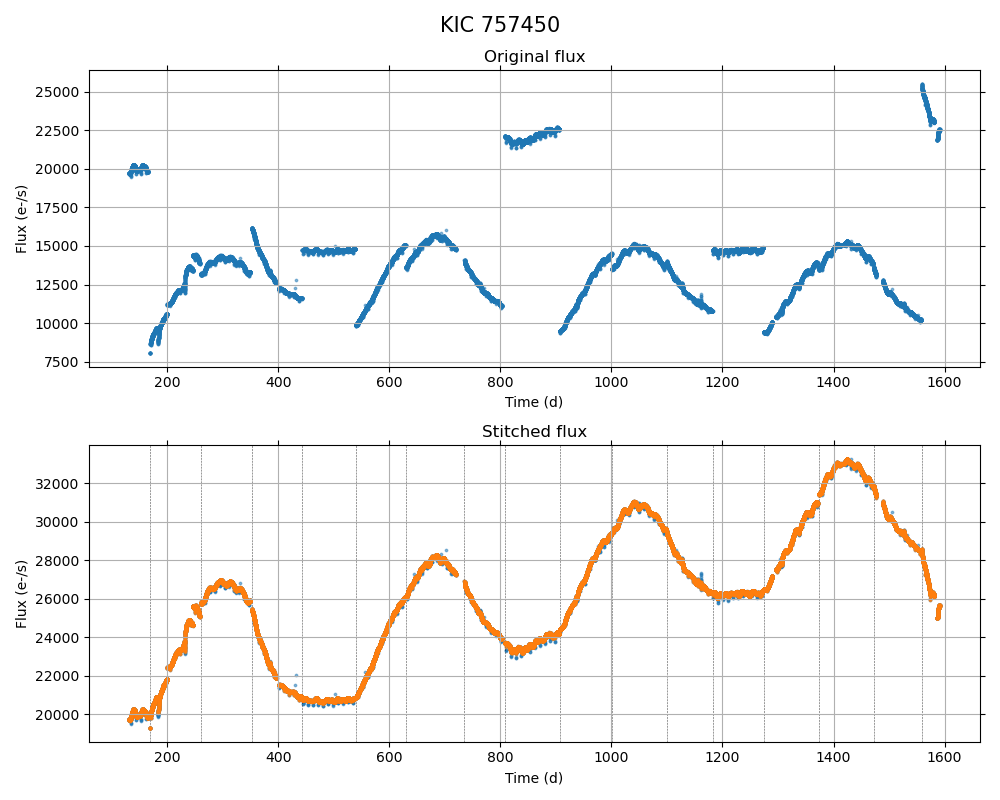

In [ ]:
lc = Lightcurve()
lc.load_kbonus(
    "../../kbonus/data/0007/000757450/hlsp_kbonus-bkg_kepler_kepler_kic-000757450_kepler_v1.0_lc.fits"
)

plt.close("all")
fig, (ax0, ax1) = plt.subplots(2, figsize=(10, 8), dpi=100)

lc.plot_flux(ax=ax0, title="Original flux")

# lc.remove_quality()
lc.debug = False

lc.stitch(
    # this is a list of dictionnaries, each dictionnary being a method to stitch:
    # it is possible to use multiple times the same method with different options to compare them
    stitching_mode=[
        {
            # the name of the method (total-mean, tips-mean, tips-poly-1, or tips-poly-2)
            "method": "total-mean",
            # the minimum number of days in the jump to use this method
            "min-jump": 10,
        },
        {
            "method": "tips-mean",
            # the maximum lenght of the tip
            "max-width": 30,
            # the maximum number of days in the jump to use this method
            "max-jump": 5,
            # the maximum "jump lenght / tip lenght" ratio before ditching the method
            "max-jump-multiplicator": 3,
        },
        {
            "method": "tips-poly-1",
            # the minimum number of days in the tip to use this method
            "min-width": 5,
            # the maximum lenght of the tip (may be smaller if the section is not long enought,
            # hence why there is a min-width option if we only want to use the method if enough data)
            "max-width": 15,
            # the maximum number of days in the jump to use this method
            "max-jump": 10,
        },
        {
            "method": "tips-poly-1",
            # the minimum number of days in the tip to use this method
            "min-width": 20,
            # the maximum lenght of the tip (may be smaller if the section is not long enought,
            # hence why there is a min-width option if we only want to use the method if enough data)
            "max-width": 30,
            # the maximum number of days in the jump to use this method
            "max-jump": 30,
        },
    ]
)

lc.debug = False
lc.plot_flux(ax=ax1, title="Stitched flux")
lc.plot_jumps(ax1)

lc.remove_outliers("sigma_clipping", threshold=5, normalize_period_cut=5, sector_by_sector=True)
lc.plot_flux(ax=ax1, title="Stitched flux")

lc.resample()
lc.normalize_sin4_filter(55, divide=True)
lc.flux_to_ppm()

lc.print_operations()

fig.suptitle(lc.object_name, fontsize=15)
fig.tight_layout()

In [15]:
lc.dt_median * 24

0.49040721729397774

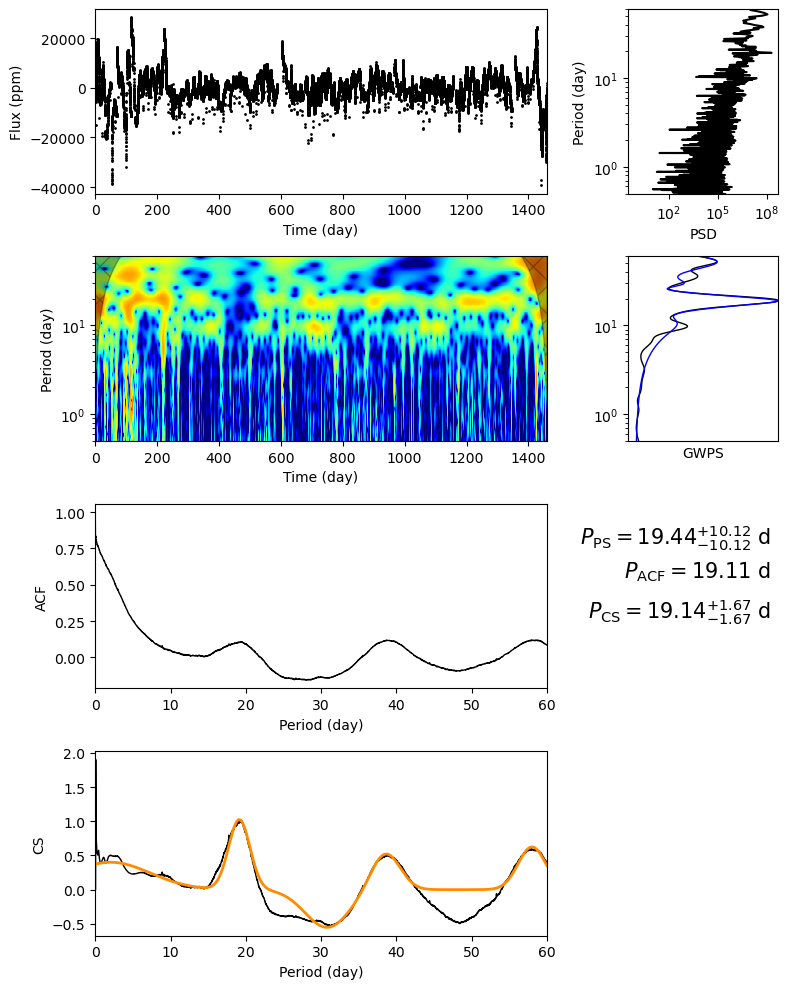

In [48]:
starprivateer_wrapper(lc.time, lc.flux, type_prot_analysis="ACF")